In [9]:
from nlb_tools.nwb_interface import NWBDataset
from nlb_tools.make_tensors import make_train_input_tensors, make_eval_input_tensors, make_eval_target_tensors, save_to_h5

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import os

In [25]:
data_root = '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/raw/dandi'
path = os.path.join(data_root, '000129/sub-Indy')
dataset = NWBDataset(path, "*train", split_heldout=False)

has_change = dataset.data.target_pos.fillna(-1000).diff(axis=0).any(axis=1) # filling NaNs with arbitrary scalar to treat as one block
# Find if target pos change corresponds to NaN-padded gap between files
change_nan = dataset.data[has_change].isna().any(axis=1)
# Drop trials containing the gap and immediately before and after, as those trials may be cut short
drop_trial = (change_nan | change_nan.shift(1, fill_value=True) | change_nan.shift(-1, fill_value=True))[:-1]
# Add start and end times to trial info
change_times = dataset.data.index[has_change]
start_times = change_times[:-1][~drop_trial]
end_times = change_times[1:][~drop_trial]
# Get target position per trial
target_pos = dataset.data.target_pos.loc[start_times].to_numpy().tolist()
# Compute reach distance and angle
reach_dist = dataset.data.target_pos.loc[end_times - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times - pd.Timedelta(1, 'ms')].to_numpy()
reach_angle = np.arctan2(reach_dist[:, 1], reach_dist[:, 0]) / np.pi * 180
# Create trial info
dataset.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times)),
    'start_time': start_times,
    'end_time': end_times,
    'target_pos': target_pos,
    'reach_dist_x': reach_dist[:, 0],
    'reach_dist_y': reach_dist[:, 1],
    'reach_angle': reach_angle,
})

bin_width = 5
dataset.resample(bin_width)
suffix = '' if (bin_width == 5) else f'_{int(round(bin_width))}'

In [22]:
# Calculate speed and call `calculate_onset`
speed = np.linalg.norm(dataset.data.finger_vel, axis=1)
dataset.data['speed'] = speed
peak_times = dataset.calculate_onset('speed', 0.05)

## Prep data
dataset.smooth_spk(20, name='smth_20', ignore_nans=True)

# Lag velocity by 120 ms relative to neural data
lag = 120
lag_bins = int(round(lag / dataset.bin_width))
nans = dataset.data.finger_vel.x.isna().reset_index(drop=True)
rates = dataset.data.spikes_smth_20[~nans.to_numpy() & ~nans.shift(-lag_bins, fill_value=True).to_numpy()].to_numpy()
vel = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].to_numpy()
vel_index = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].index

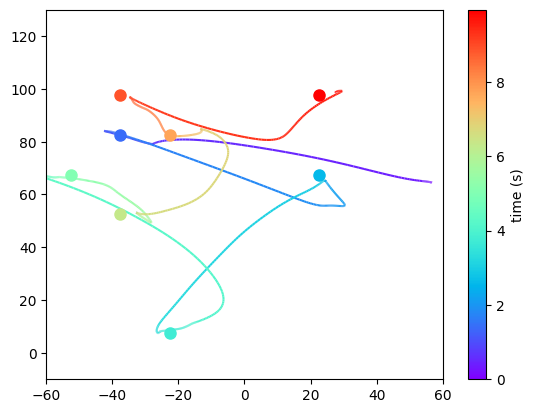

In [26]:
# Extract start and end times, target positions
start = dataset.trial_info.iloc[0].start_time # arbitrarily using 1st through 6th reaches
end = dataset.trial_info.iloc[7].end_time - pd.Timedelta(1, 'ms')
targets = dataset.trial_info.target_pos.iloc[0:8].to_numpy().tolist()
tts = dataset.trial_info.end_time.iloc[0:8] - start

# Get cursor position data
reach_data = dataset.data.cursor_pos.loc[start:end].to_numpy().reshape(-1, 1, 2)
reach_seg = np.concatenate([reach_data[:-1], reach_data[1:]], axis=1)
# Split into collection of lines for color gradient
lc = LineCollection(reach_seg, cmap='rainbow', norm=plt.Normalize(0, len(reach_seg) * dataset.bin_width / 1000))
lc.set_array(np.arange(len(reach_seg)) * dataset.bin_width / 1000)

# Plot lines and add targets
ax = plt.axes()
lines = ax.add_collection(lc)
for tt, target in zip(tts, targets):
    ax.plot(target[0], target[1], marker='o', markersize=8, color=plt.get_cmap('rainbow')(tt.total_seconds() * 1000 / dataset.bin_width / len(reach_seg)))
ax.set_xlim(-60, 60)
ax.set_ylim(-10, 130)
plt.colorbar(lines, label='time (s)')
plt.show()

In [9]:
from foundational_ssm.constants import (
    DATASET_GROUP_DIMS,
    DATASET_GROUP_TO_IDX,
    MAX_NEURAL_INPUT_DIM,
    MAX_BEHAVIOR_INPUT_DIM,
    DATA_ROOT,
    MC_MAZE_CONFIG,
    MC_RTT_CONFIG,
    NLB_CONFIGS,
    NLB_DATA_ROOT,
    parse_session_id,
)
import h5py
import os


def h5_to_dict(h5obj):
    """Recursive function that reads HDF5 file to dict

    Parameters
    ----------
    h5obj : h5py.File or h5py.Group
        File or group object to load into a dict
    
    Returns
    -------
    dict of np.array
        Dict mapping h5obj keys to arrays
        or other dicts
    """
    data_dict = {}
    for key in h5obj.keys():
        if isinstance(h5obj[key], h5py.Group):
            data_dict[key] = h5_to_dict(h5obj[key])
        else:
            data_dict[key] = h5obj[key][()]
    return data_dict


task_config = NLB_CONFIGS['mc_rtt']
    
data_path = os.path.join(NLB_DATA_ROOT, task_config.H5_FILE_NAME)
trial_info_path = os.path.join(NLB_DATA_ROOT, task_config.TRIAL_INFO_FILE_NAME)
with h5py.File(data_path, 'r') as h5file:
    dataset_dict = h5_to_dict(h5file)

In [14]:
dataset_dict['train_spikes_heldout_forward'].shape

(1080, 40, 32)

In [1]:
from foundational_ssm.data_utils.loaders import get_nlb_train_val_loaders
train_dataset, train_loader, val_dataset, val_loader = get_nlb_train_val_loaders()

In [2]:
for batch in train_loader:
    break

In [5]:
batch['neural_input'].shape

(256, 120, 130)

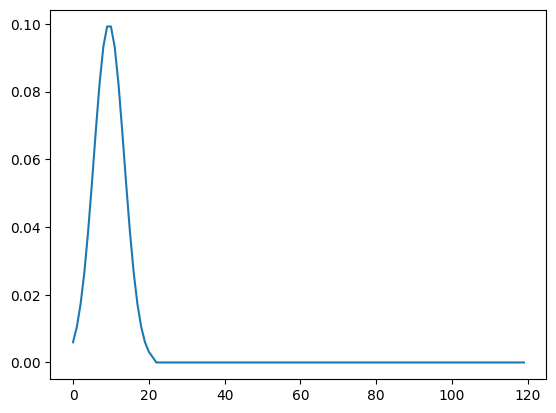

In [4]:
import matplotlib.pyplot as plt
plt.plot(batch['neural_input'][0,:,1])